In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, Sequential
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras import initializers

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

tf.random.set_seed(42)

In [2]:
# Parameters
img_size = 128
latent_dims = 128
learning_rate = 0.001
n_epochs = 40
variational_beta = 1
batch_size = 128

In [3]:
def load_image_names(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

In [4]:
root_dir = "celeba_gan/"
names = load_image_names("./" + root_dir + "list_eval_partition.txt")

In [5]:
# Stack image names with the corresponding partition offset
train_files, valid_files, test_files = [], [], []

for name in names:
    if name[-1] == "0":
        train_files.append(os.path.join(os.getcwd(), root_dir, "img_align_celeba", name[:-2]))
    elif name[-1] == "1":
        valid_files.append(os.path.join(os.getcwd(), root_dir, "img_align_celeba", name[:-2]))
    elif name[-1] == "2":
        test_files.append(os.path.join(os.getcwd(), root_dir, "img_align_celeba", name[:-2]))

In [6]:
def load_and_preprocess_image(file_path, img_size, is_training):
    # Load the image from the file path
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)

    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    
    # Resize the image horizontally
    image = tf.image.resize(image, size=[height, img_size])
    
    # Convert the resized image to uint8 for display or saving
    image = tf.cast(image, tf.uint8)
    
    height_offset = tf.cast((height - img_size) / 4, tf.int32)
    
    new_height = height - 2 * height_offset
    new_width = tf.shape(image)[1]
    
    print(new_height)
    # Crop the image
    image = tf.image.crop_to_bounding_box(image, 
                                          offset_height=height_offset, 
                                          offset_width=0, 
                                          target_height=new_height, 
                                          target_width=new_width)


    # Resize the image vertically
    image = tf.image.resize(image, size=[img_size, img_size])
    
    image = tf.cast(image, tf.float32) / 127.5 - 1.0

    return image

def build_dataset(file_list, img_size, n, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices(file_list[:n])
    dataset = dataset.map(lambda x: load_and_preprocess_image(x, img_size, is_training), num_parallel_calls=tf.data.AUTOTUNE)
    #if is_training:
    #    dataset = dataset.shuffle(buffer_size=32)


    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.take(n // 32)
    
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [7]:
# Create training dataset
train_dataset = build_dataset(train_files, img_size, 10000, is_training=True)
valid_dataset = build_dataset(valid_files, img_size, 1250, is_training=False)
test_dataset = build_dataset(test_files, img_size, 1250, is_training=False)

Tensor("sub_1:0", shape=(), dtype=int32)
Tensor("sub_1:0", shape=(), dtype=int32)
Tensor("sub_1:0", shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8272059..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98829657..0.81170344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96721816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99356616..1.0].
Clipping input data to the valid ra

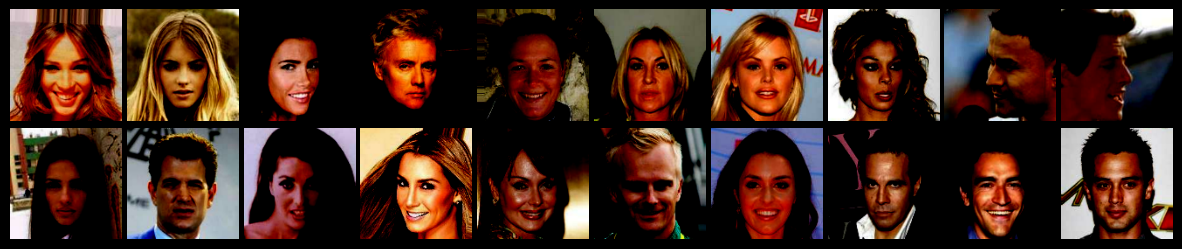

In [8]:
# Create a figure with a black background
fig = plt.figure(figsize=(15, 3))
fig.patch.set_facecolor('black')

# Display 20 images in a grid of 2 rows and 10 columns
for i, batch in enumerate(train_dataset.take(1)):
    for j in range(20):
        ax = plt.subplot(2, 10, j + 1)
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        ax.imshow((batch[j].numpy()))
    break

# Adjust layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [9]:
# Define the custom weight initialization function
def weight_init(model):
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Conv2DTranspose):
            layer.kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)
            if layer.bias is not None:
                layer.bias_initializer = initializers.Zeros()
        
        if isinstance(layer, layers.Dense):
            layer.kernel_initializer = tf.keras.initializers.HeUniform()
            if layer.bias is not None:
                layer.bias_initializer = initializers.Zeros()
        

In [10]:
# Define Encoder
inputs = layers.Input(shape=(128, 128, 3))
x = layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
out1 = layers.Dense(latent_dims)(x)
out2 = layers.Dense(latent_dims)(x)

# Create the model
encoder = Model(inputs=inputs, outputs=[out1, out2], name="Encoder")

encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,568 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     32,832 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    131,200 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    524,544 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  2,097,664 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,048,704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  1,048,704 │ flatten[0][0]   

 Total params: 4,889,184 (18.65 MB)

 Trainable params: 4,887,200 (18.64 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [11]:
latent_inputs = tf.keras.Input(shape=(latent_dims,))
x = layers.Dense(512 * 4 * 4)(latent_inputs)
x = layers.Reshape((4, 4, 512))(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
out = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)

# Create the model
decoder = Model(inputs=latent_inputs, outputs=out, name="decoder")

decoder.summary()

/Users/alimahdi/miniforge3/envs/metal/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845,987 (14.67 MB)

 Trainable params: 3,845,027 (14.67 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# Initialize weights for encoder and decoder
weight_init(encoder)
weight_init(decoder)

# Print initializer details
for layer in encoder.layers:
    print(f"Layer: {layer.name}")
    if hasattr(layer, 'kernel_initializer'):
        print(f"  Kernel Initializer: {layer.kernel_initializer.__class__.__name__}")
    if hasattr(layer, 'bias_initializer'):
        print(f"  Bias Initializer: {layer.bias_initializer.__class__.__name__}")

Layer: input_layer
Layer: conv2d
  Kernel Initializer: RandomNormal
  Bias Initializer: Zeros
Layer: batch_normalization
Layer: re_lu
Layer: conv2d_1
  Kernel Initializer: RandomNormal
  Bias Initializer: Zeros
Layer: batch_normalization_1
Layer: re_lu_1
Layer: conv2d_2
  Kernel Initializer: RandomNormal
  Bias Initializer: Zeros
Layer: batch_normalization_2
Layer: re_lu_2
Layer: conv2d_3
  Kernel Initializer: RandomNormal
  Bias Initializer: Zeros
Layer: batch_normalization_3
Layer: re_lu_3
Layer: conv2d_4
  Kernel Initializer: RandomNormal
  Bias Initializer: Zeros
Layer: batch_normalization_4
Layer: re_lu_4
Layer: flatten
Layer: dense
  Kernel Initializer: HeUniform
  Bias Initializer: Zeros
Layer: dense_1
  Kernel Initializer: HeUniform
  Bias Initializer: Zeros


In [13]:
def vae_loss(recon_x, x, mu, logvar):
    # Binary Cross Entropy (BCE) Loss
    bce = tf.reduce_mean(tf.square(recon_x - x))
    
    # Kullback-Leibler Divergence (KLD)
    kld = -0.5 * tf.reduce_mean(tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1))
    return bce + kld * 0.1

In [14]:
class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self, img_size, latent_dims):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, x, training=False):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar, training)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar, training):
        if training:
            # Reparameterization trick
            std = tf.exp(0.5 * logvar)
            eps = tf.random.normal(shape=tf.shape(std))
            return eps * std + mu
        else:
            return mu

In [15]:
# Instantiate the model
vae = VariationalAutoEncoder(img_size=img_size, latent_dims=latent_dims)

# Function to count the number of trainable parameters
def count_parameters(model):
    return sum(np.prod(var.shape) for var in model.trainable_variables)

# Count the parameters
n_params = count_parameters(vae)
print('Number of parameters: %d' % n_params)

Number of parameters: 8732227


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999, decay=1e-5)
valid_loss_min = np.Inf 

train_loss_list = []
valid_loss_list = []

# Training and validation loop
for epoch in range(1, n_epochs + 1):
    # Initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the VAE model
    for batch_idx, batch in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # VAE reconstruction
            batch_recon, latent_mu, latent_logvar = vae(batch, training=True)
            
            # Compute reconstruction error
            loss = vae_loss(batch_recon, batch, latent_mu, latent_logvar)
        
        # Backpropagation and gradient update
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
        
        # Update training loss
        train_loss += (loss.numpy() - train_loss) / (batch_idx + 1)

    
    # Validate the VAE model
    for batch_idx, batch in enumerate(valid_dataset):
        # VAE reconstruction
        batch_recon, latent_mu, latent_logvar = vae(batch, training=False)
        
        # Compute reconstruction error
        loss = vae_loss(batch_recon, batch, latent_mu, latent_logvar)
        
        # Update validation loss
        valid_loss += (loss.numpy() - valid_loss) / (batch_idx + 1)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # Print training/validation statistics
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")
    
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...")
        vae.save_weights("vae.weights.h5")  # Save model weights
        valid_loss_min = valid_loss

/Users/alimahdi/miniforge3/envs/metal/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch: 1 	Training Loss: 0.862566 	Validation Loss: 0.345291
Validation loss decreased (inf --> 0.345291). Saving model ...
Epoch: 2 	Training Loss: 0.372738 	Validation Loss: 0.325228
Validation loss decreased (0.345291 --> 0.325228). Saving model ...
Epoch: 3 	Training Loss: 0.378432 	Validation Loss: 0.280692
Validation loss decreased (0.325228 --> 0.280692). Saving model ...
Epoch: 4 	Training Loss: 0.321062 	Validation Loss: 0.319645
Epoch: 5 	Training Loss: 0.323009 	Validation Loss: 0.332978
Epoch: 6 	Training Loss: 0.285485 	Validation Loss: 0.377093
Epoch: 7 	Training Loss: 0.290707 	Validation Loss: 0.346404
Epoch: 8 	Training Loss: 0.274345 	Validation Loss: 0.388608
Epoch: 9 	Training Loss: 0.262243 	Validation Loss: 0.279646
Validation loss decreased (0.280692 --> 0.279646). Saving model ...
Epoch: 10 	Training Loss: 0.267248 	Validation Loss: 0.255263
Validation loss decreased (0.279646 --> 0.255263). Saving model ...
Epoch: 11 	Training Loss: 0.261403 	Validation Loss: 0

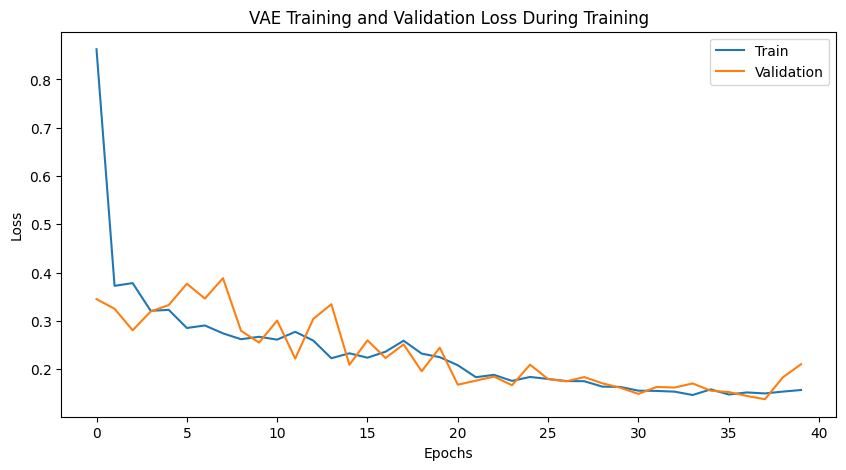

In [17]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.title("VAE Training and Validation Loss During Training")
plt.plot(train_loss_list, label="Train")
plt.plot(valid_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
images = next(iter(train_dataset))

<Figure size 640x480 with 0 Axes>

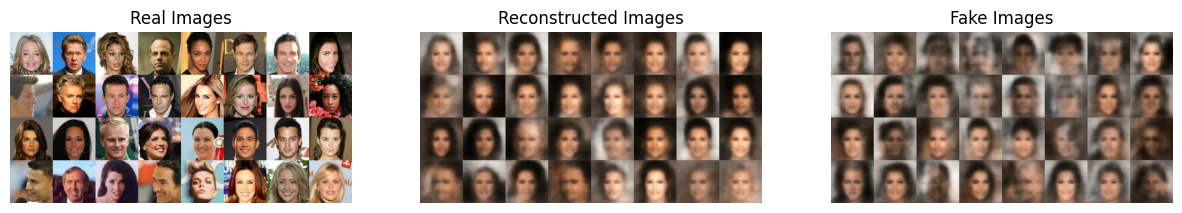

In [19]:
# Adjust layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

def normalize(image):
    return np.array(255 * (image - image.min()) / (image.max() - image.min()), dtype=np.uint8)

# Function to load and preprocess data
def preprocess_image(image):
    image = tf.image.resize(image, [128, 128])  # Resize if needed
    #image = (image / 255.0)  # Normalize to [0, 1]
    return image

# Function to plot images
def plot_images(real_images, reconstructed_images, fake_images):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Real Images
    axs[0].axis("off")
    axs[0].set_title("Real Images")
    real_images_grid = tf.concat([tf.concat([img for img in real_images[i:i+8]], axis=1) for i in range(0, 32, 8)], axis=0)
    axs[0].imshow(normalize(real_images_grid.numpy()))

    # Reconstructed Images
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    reconstructed_images_grid = tf.concat([tf.concat([img for img in reconstructed_images[i:i+8]], axis=1) for i in range(0, 32, 8)], axis=0)
    axs[1].imshow(normalize(reconstructed_images_grid.numpy()))

    # Fake Images
    axs[2].axis("off")
    axs[2].set_title("Fake Images")
    fake_images_grid = tf.concat([tf.concat([img for img in fake_images[i:i+8]], axis=1) for i in range(0, 32, 8)], axis=0)
    axs[2].imshow(normalize(fake_images_grid.numpy()))

    plt.savefig('output.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


images = preprocess_image(images)

# Reconstruct Images
reconstructed_images = vae(images, training=False)[0]

# Generate Fake Images
latent = tf.random.normal([128, latent_dims])
fake_images = vae.decoder(latent, training=False)

# Plot images
plot_images(images[:32], reconstructed_images[:32], fake_images[:32])

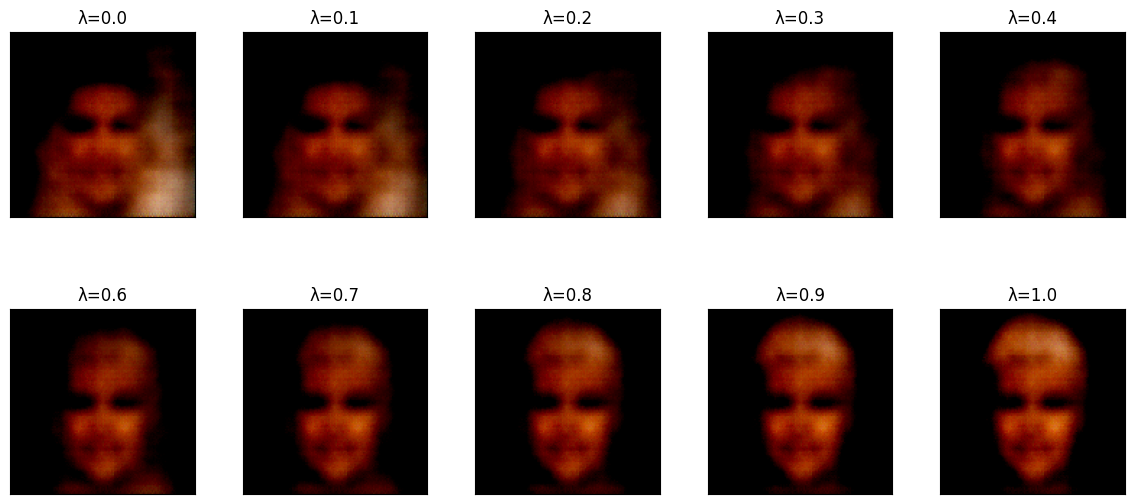

In [20]:
def interpolation(model, img1, img2, lambda_):
    # Add batch dimension to images if not already present
    img1 = tf.expand_dims(img1, axis=0)
    img2 = tf.expand_dims(img2, axis=0)

    # Encode the images to get latent vectors
    latent_1, _ = model.encoder(img1, training=False)
    latent_2, _ = model.encoder(img2, training=False)

    # Interpolate between the two latent vectors
    inter_latent = lambda_ * latent_1 + (1 - lambda_) * latent_2

    # Decode the interpolated latent vector to reconstruct the image
    inter_image = model.decoder(inter_latent, training=False)

    # Remove batch dimension
    inter_image = tf.squeeze(inter_image, axis=0)

    return inter_image

# Assuming images are preprocessed and normalized between 0 and 1
images = next(iter(test_dataset))
lambda_range = np.linspace(0, 1, 10)

# Create a figure for the subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()

for idx, (ax, lambda_) in enumerate(zip(axs, lambda_range)):
    inter_image = interpolation(vae, images[0], images[1], lambda_)
   
    # Clamp values between 0 and 1 (if necessary)
    inter_image = tf.clip_by_value(inter_image, 0, 1)
    
    # Move axis if needed (TensorFlow defaults to channel-last format)
    image = inter_image.numpy()
   
    # Display the image
    ax.imshow(image)
    ax.set_title(f'λ={lambda_:.1f}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()